In [ ]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Paths
# dataset_dir = "Insects Dataset\\farm_insects"
# output_dir = "split"

# train_ratio = 0.7  # 70% for training
# val_ratio = 0.15   # 15% for validation
# test_ratio = 0.15  # 15% for testing

# # Create output directories
# for split in ['train', 'val', 'test']:
#     for class_name in os.listdir(dataset_dir):
#         os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# # Split and move files
# for class_name in os.listdir(dataset_dir):
#     class_path = os.path.join(dataset_dir, class_name)
#     images = os.listdir(class_path)

#     # Split dataset into train, validation, and test
#     train_images, temp_images = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
#     val_images, test_images = train_test_split(temp_images, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

#     # Move images to respective folders
#     for image in train_images:
#         shutil.copy(os.path.join(class_path, image), os.path.join(output_dir, 'train', class_name, image))
#     for image in val_images:
#         shutil.copy(os.path.join(class_path, image), os.path.join(output_dir, 'val', class_name, image))
#     for image in test_images:
#         shutil.copy(os.path.join(class_path, image), os.path.join(output_dir, 'test', class_name, image))

# print("Dataset successfully split into train, validation, and test sets.")


In [ ]:
import warnings
!pip install evaluate

warnings.filterwarnings("ignore")
import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)


# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [ ]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# use https://huggingface.co/docs/datasets/image_load for reference

from pathlib import Path
from tqdm import tqdm
import pandas as pd

# Specify the folder path as a Path object
folder_path = Path('/content/drive/MyDrive/Project/archive (2)/farm_insects')

# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory using glob
for file in tqdm(sorted(folder_path.glob('*/*.*'))):  # Recursively search for image files
    label = file.parent.name  # Extract the label from the parent folder name
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(f"Total images: {len(file_names)}, Total labels: {len(labels)}")

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame({"image": file_names, "label": labels})
print(f"Dataframe shape: {df.shape}")
print(df.head())






# # Import necessary libraries
# image_dict = {}

# # Define the list of file names
# from pathlib import Path
# from tqdm import tqdm
# import os
# # Initialize empty lists to store file names and labels
# file_names = []
# labels = []

# # Iterate through all image files in the specified directory
# for file in tqdm(sorted((Path('Insects Dataset/farm_insects/').glob('*/*.*')))):
#     label = str(file).split('/')[-2]  # Extract the label from the file path
#     labels.append(label)  # Add the label to the list
#     file_names.append(str(file))  # Add the file path to the list

# # Print the total number of file names and labels
# print(len(file_names), len(labels))

# # Create a pandas dataframe from the collected file names and labels
# df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
# print(df.shape)

100%|██████████| 1591/1591 [00:00<00:00, 151734.64it/s]

Total images: 1591, Total labels: 1591
Dataframe shape: (1591, 2)
                                               image  \
0  /content/drive/MyDrive/Project/archive (2)/far...   
1  /content/drive/MyDrive/Project/archive (2)/far...   
2  /content/drive/MyDrive/Project/archive (2)/far...   
3  /content/drive/MyDrive/Project/archive (2)/far...   
4  /content/drive/MyDrive/Project/archive (2)/far...   

                                  label  
0  Africanized Honey Bees (Killer Bees)  
1  Africanized Honey Bees (Killer Bees)  
2  Africanized Honey Bees (Killer Bees)  
3  Africanized Honey Bees (Killer Bees)  
4  Africanized Honey Bees (Killer Bees)  


In [ ]:
df.head()

,image,label
0,/content/drive/MyDrive/Project/archive (2)/far...,Africanized Honey Bees (Killer Bees)
1,/content/drive/MyDrive/Project/archive (2)/far...,Africanized Honey Bees (Killer Bees)
2,/content/drive/MyDrive/Project/archive (2)/far...,Africanized Honey Bees (Killer Bees)
3,/content/drive/MyDrive/Project/archive (2)/far...,Africanized Honey Bees (Killer Bees)
4,/content/drive/MyDrive/Project/archive (2)/far...,Africanized Honey Bees (Killer Bees)


In [ ]:
df['label'].unique()

array(['Africanized Honey Bees (Killer Bees)', 'Aphids', 'Armyworms',
       'Brown Marmorated Stink Bugs', 'Cabbage Loopers', 'Citrus Canker',
       'Colorado Potato Beetles', 'Corn Borers', 'Corn Earworms',
       'Fall Armyworms', 'Fruit Flies', 'Spider Mites', 'Thrips',
       'Tomato Hornworms', 'Western Corn Rootworms'], dtype=object)

In [ ]:
# random oversampling of minority class
# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)


# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)


(1785, 2)


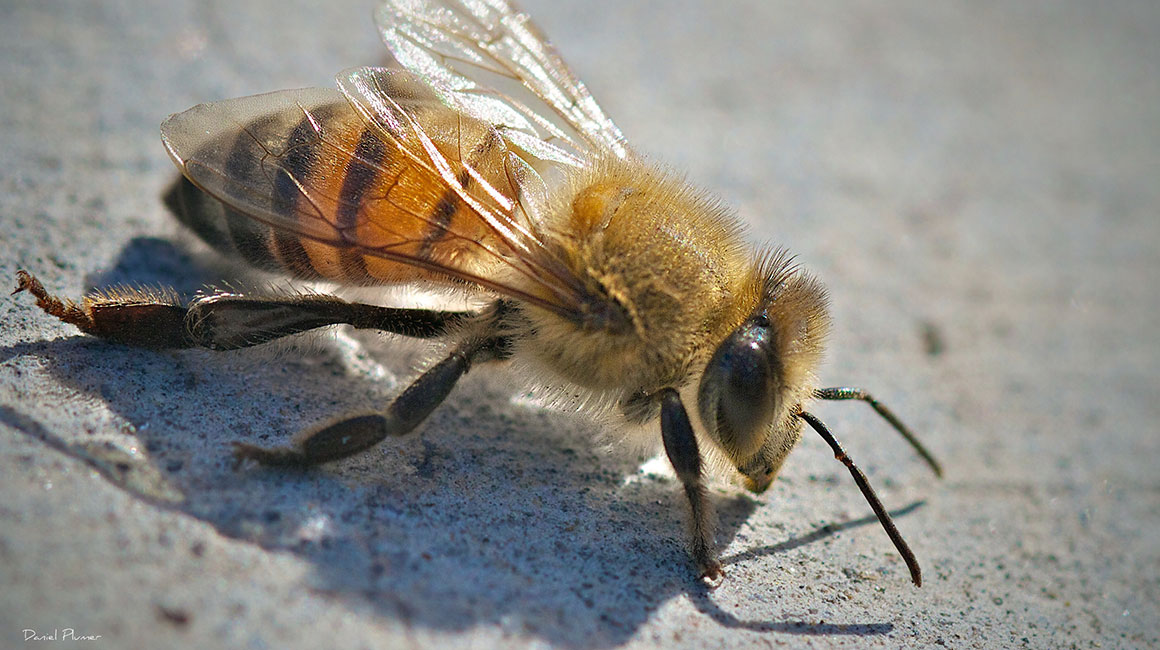

In [ ]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())
# Display the first image in the dataset
dataset[0]["image"]

In [ ]:
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['Africanized Honey Bees (Killer Bees)', 'Africanized Honey Bees (Killer Bees)', 'Africanized Honey Bees (Killer Bees)', 'Africanized Honey Bees (Killer Bees)', 'Africanized Honey Bees (Killer Bees)']


In [ ]:
labels_list = ['Fall Armyworms', 'Western Corn Rootworms', 'Colorado Potato Beetles', 'Thrips', 'Corn Earworms', 'Cabbage Loopers',
               'Armyworms', 'Brown Marmorated Stink Bugs', 'Tomato Hornworms', 'Citrus Canker', 'Aphids', 'Corn Borers', 'Fruit Flies',
               'Africanized Honey Bees (Killer Bees)', 'Spider Mites'] #list(set(labels))

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Fall Armyworms', 1: 'Western Corn Rootworms', 2: 'Colorado Potato Beetles', 3: 'Thrips', 4: 'Corn Earworms', 5: 'Cabbage Loopers', 6: 'Armyworms', 7: 'Brown Marmorated Stink Bugs', 8: 'Tomato Hornworms', 9: 'Citrus Canker', 10: 'Aphids', 11: 'Corn Borers', 12: 'Fruit Flies', 13: 'Africanized Honey Bees (Killer Bees)', 14: 'Spider Mites'} 

Mapping of Labels to IDs: {'Fall Armyworms': 0, 'Western Corn Rootworms': 1, 'Colorado Potato Beetles': 2, 'Thrips': 3, 'Corn Earworms': 4, 'Cabbage Loopers': 5, 'Armyworms': 6, 'Brown Marmorated Stink Bugs': 7, 'Tomato Hornworms': 8, 'Citrus Canker': 9, 'Aphids': 10, 'Corn Borers': 11, 'Fruit Flies': 12, 'Africanized Honey Bees (Killer Bees)': 13, 'Spider Mites': 14}


In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']

test_data = dataset['test']

Map:   0%|          | 0/1785 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1785 [00:00<?, ? examples/s]

In [ ]:
model_str = "dima806/farm_insects_image_detection" #'google/vit-base-patch16-224-in21k'

processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)


# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)


_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


Size:  224


In [ ]:
train_data.set_transform(train_transforms)

test_data.set_transform(val_transforms)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    labels = torch.tensor([example['label'] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

85.810191


In [ ]:
# 85.810191
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions

    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)

    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

In [ ]:
metric_name = "accuracy"

model_name = "farm_insects_image_detection"

num_train_epochs = 5

args = TrainingArguments(
    output_dir=model_name,

    logging_dir='./logs',

    evaluation_strategy="epoch",

    learning_rate=2e-6,

    per_device_train_batch_size=64,

    per_device_eval_batch_size=32,

    num_train_epochs=num_train_epochs,


    weight_decay=0.02,


    warmup_steps=50,


    remove_unused_columns=False,


    save_strategy='epoch',

    load_best_model_at_end=True,

    save_total_limit=1,

    report_to="none"
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.evaluate()


{'eval_loss': 1.1107807159423828,
 'eval_model_preparation_time': 0.0306,
 'eval_accuracy': 0.907563025210084,
 'eval_runtime': 511.5574,
 'eval_samples_per_second': 1.396,
 'eval_steps_per_second': 0.045}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,1.109613,0.030600,0.907563
2,No log,1.106350,0.030600,0.907563
3,No log,1.101142,0.030600,0.908964
4,No log,1.097330,0.030600,0.906162
5,No log,1.096014,0.030600,0.908964


TrainOutput(global_step=85, training_loss=0.9600851619944853, metrics={'train_runtime': 12855.23, 'train_samples_per_second': 0.417, 'train_steps_per_second': 0.007, 'total_flos': 4.1501795452314624e+17, 'train_loss': 0.9600851619944853, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.0960140228271484,
 'eval_model_preparation_time': 0.0306,
 'eval_accuracy': 0.9089635854341737,
 'eval_runtime': 528.0771,
 'eval_samples_per_second': 1.352,
 'eval_steps_per_second': 0.044,
 'epoch': 5.0}

In [ ]:
outputs = trainer.predict(dataset['test'])
# outputs = Trainer.predict(test_data)

print(outputs.metrics)

{'test_loss': 1.0960140228271484, 'test_model_preparation_time': 0.0306, 'test_accuracy': 0.9089635854341737, 'test_runtime': 462.8934, 'test_samples_per_second': 1.542, 'test_steps_per_second': 0.05}


Accuracy: 0.9090
F1 Score: 0.9059


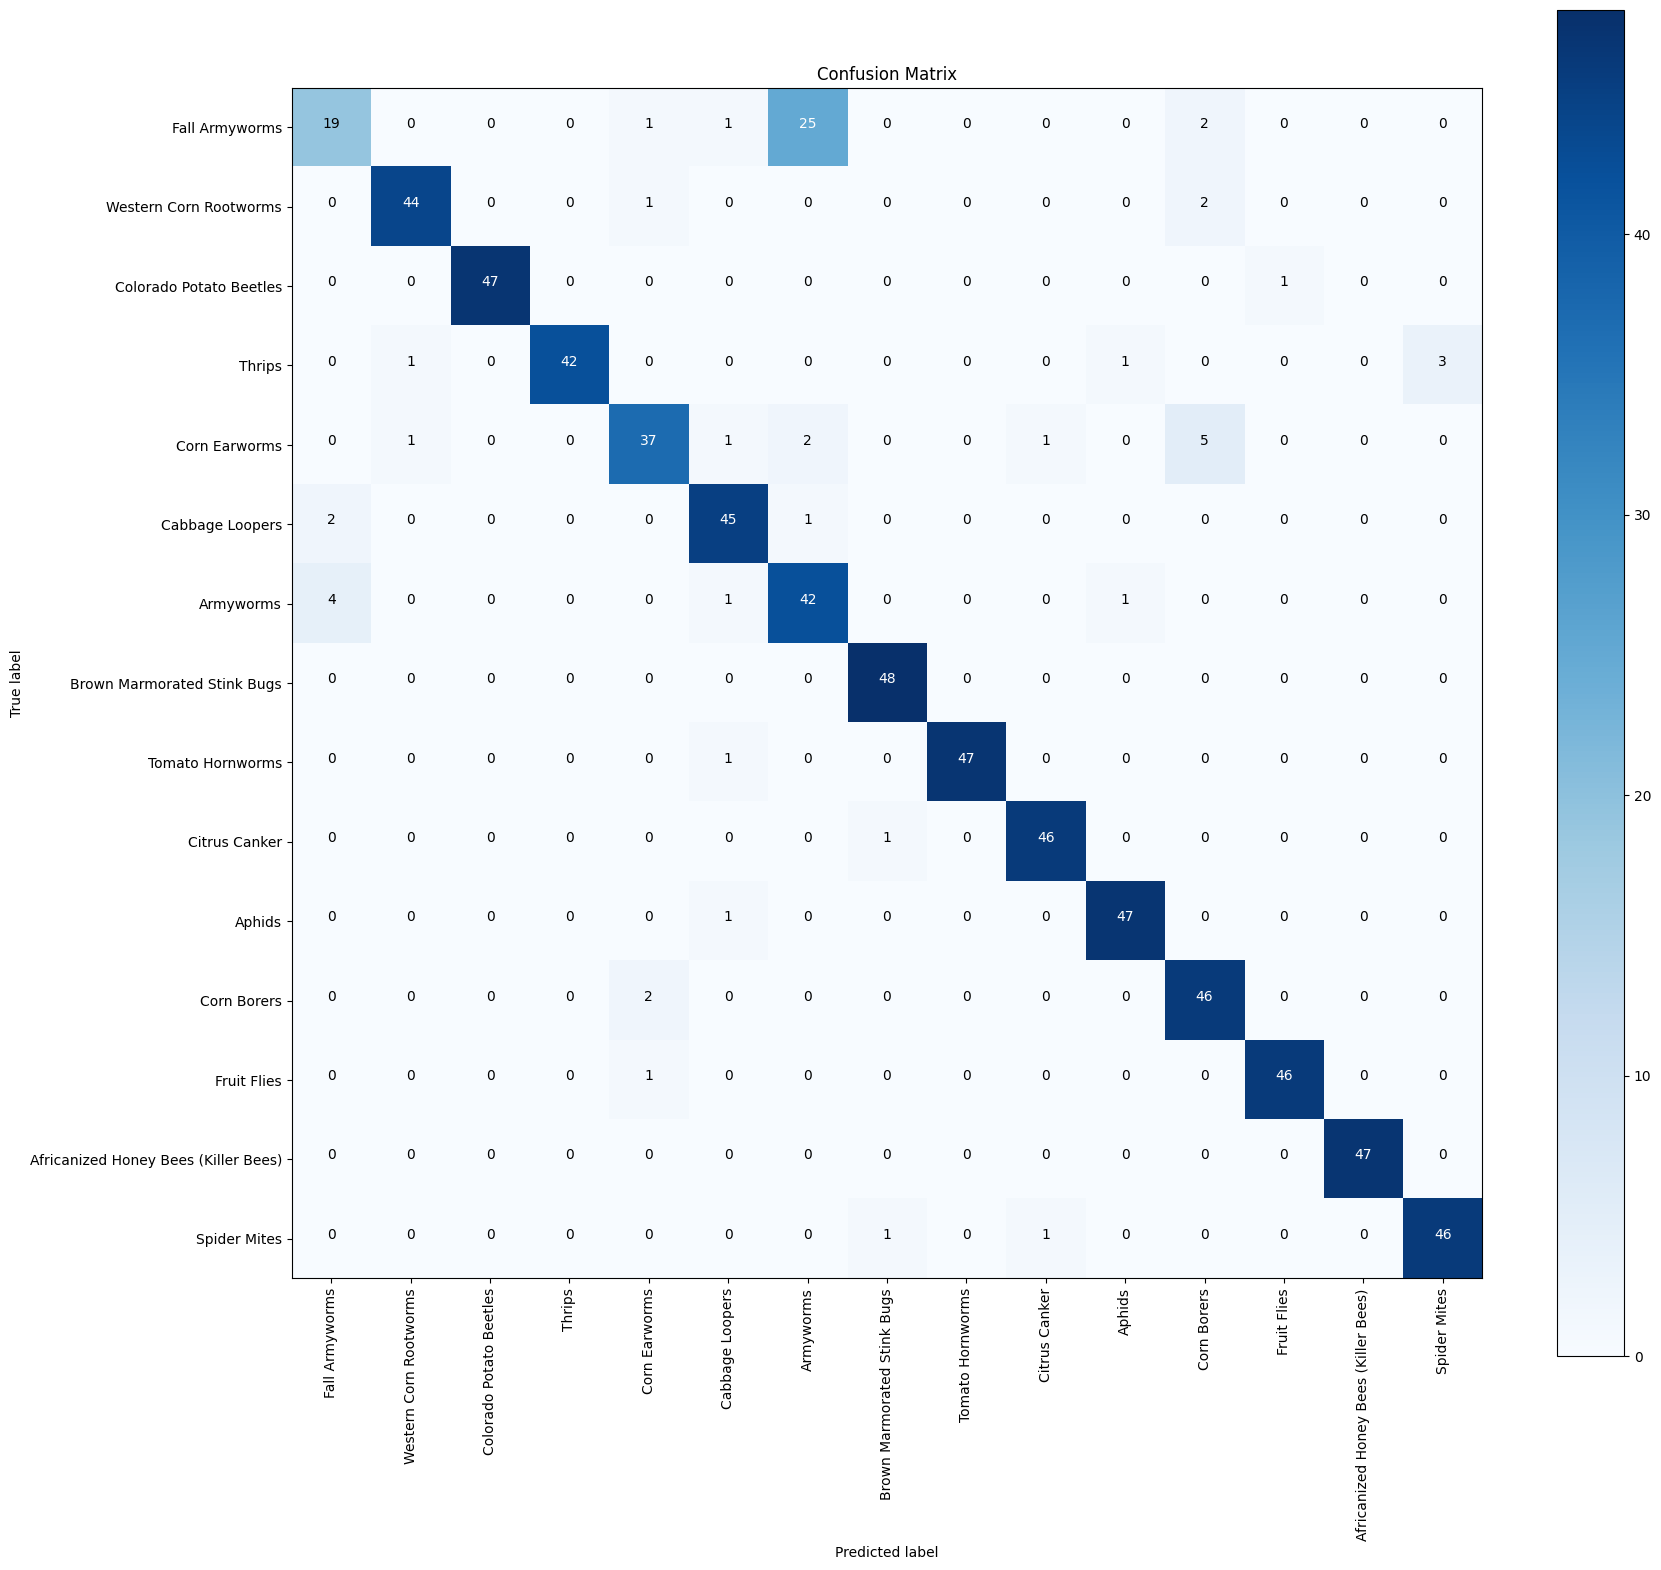


Classification report:

                                      precision    recall  f1-score   support

                      Fall Armyworms     0.7600    0.3958    0.5205        48
              Western Corn Rootworms     0.9565    0.9362    0.9462        47
             Colorado Potato Beetles     1.0000    0.9792    0.9895        48
                              Thrips     1.0000    0.8936    0.9438        47
                       Corn Earworms     0.8810    0.7872    0.8315        47
                     Cabbage Loopers     0.9000    0.9375    0.9184        48
                           Armyworms     0.6000    0.8750    0.7119        48
         Brown Marmorated Stink Bugs     0.9600    1.0000    0.9796        48
                    Tomato Hornworms     1.0000    0.9792    0.9895        48
                       Citrus Canker     0.9583    0.9787    0.9684        47
                              Aphids     0.9592    0.9792    0.9691        48
                         Corn Borers  

In [ ]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):

    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()


# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(18, 16))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))


In [ ]:
trainer.save_model()


In [ ]:
from transformers import pipeline

pipe = pipeline('image-classification', model=model_name, device=0)

Device set to use cpu


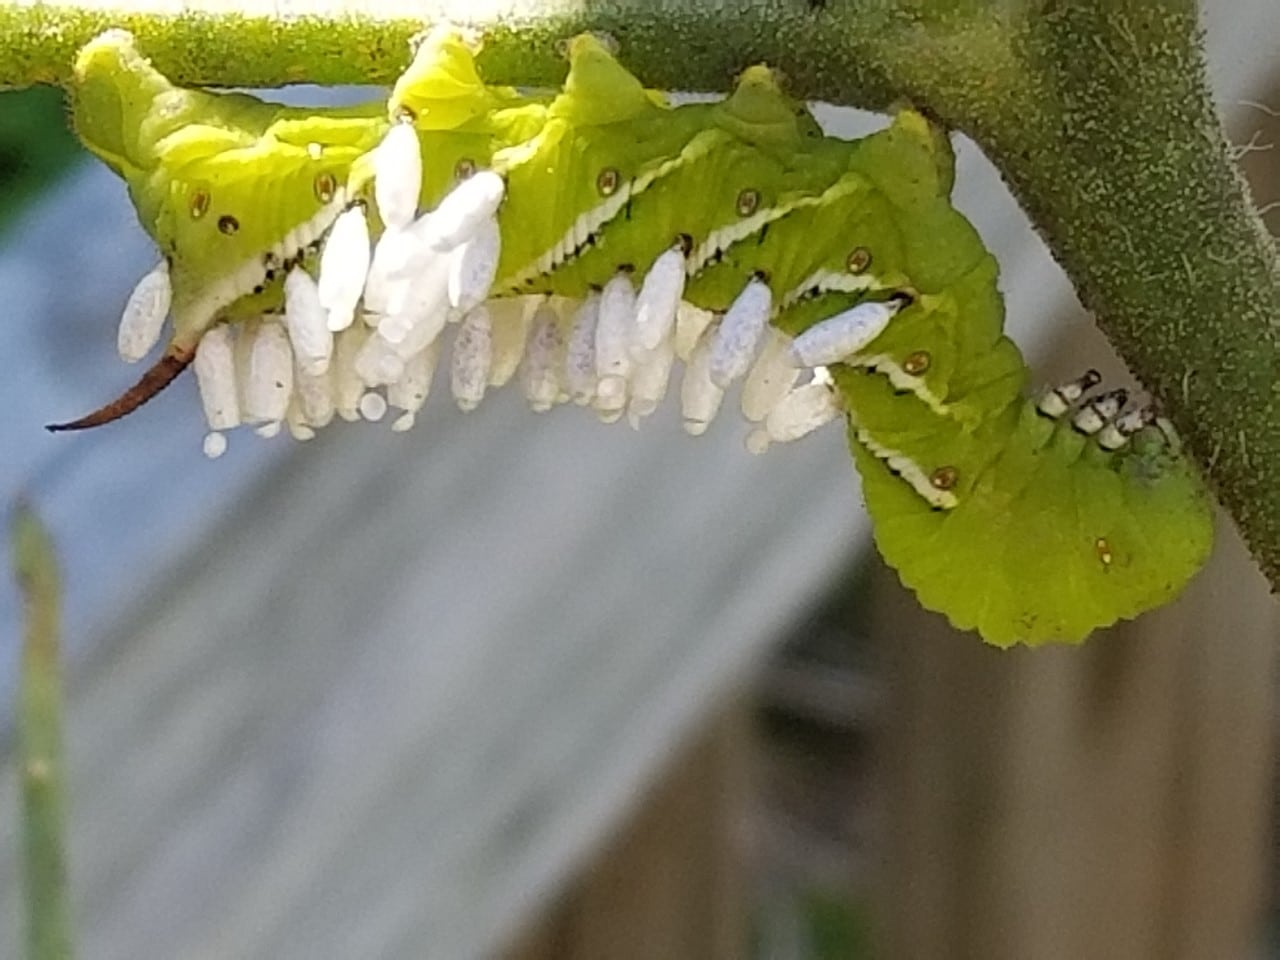

In [ ]:
image = test_data[1]["image"]

image

In [ ]:
id2label[test_data[1]["label"]]

'Tomato Hornworms'